In [344]:
using LowRankModels
using PyPlot
using CSV
using Statistics
using LaTeXStrings
using Printf
using ScikitLearn.CrossValidation: KFold

# Load Henry coefficient matrix `H`

see `xxx.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

In [345]:
henry_df = CSV.read(joinpath("..", "data", "henry_matrix_df_l_4.csv"))
H = convert(Array{Union{Float64, Missing}, 2}, henry_df[1:end, 2:end]) # the H matrix!

nm = size(H)[1] # no. of materials
ng = size(H)[2] # no. of gases

materials = String.(henry_df[:, 1]) # list of materials, order corresponding to rows in H
gases = String.(names(henry_df)[2:end]) # list of gases, order corresponding to cols in H
@assert length(materials) == nm && length(gases) == ng

## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [346]:
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2}, 
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check
    @assert sum(ismissing.(H[:, 1])) < sum(ismissing.(H[:, 5])) # first row has fewer missing values
    @assert sum(ismissing.(H[1, :])) < sum(ismissing.(H[5, :])) # first col has fewer missing values
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)

## prune matrix by selecting rows/cols with the most observations

In [347]:
nm = 100
ng = 15

H = H[1:nm, 1:ng]
materials = materials[1:nm]
gases = gases[1:ng];

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)

## standardize columns, log10-transform
* take the `log` (base 10) to learn the *order of magnitude* of the Henry coefficients
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [348]:
# log-10 transform
H = log10.(H)

# standardize the columns
for j = 1:ng
    # find ids that are not missing
    ids = .! ismissing.(H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    H[:, j] .= (H[:, j] .- mean(H[ids, j])) ./ std(H[ids, j])
end

## visualize

here, a diverging colormap is appropriate since the columns are standardized.

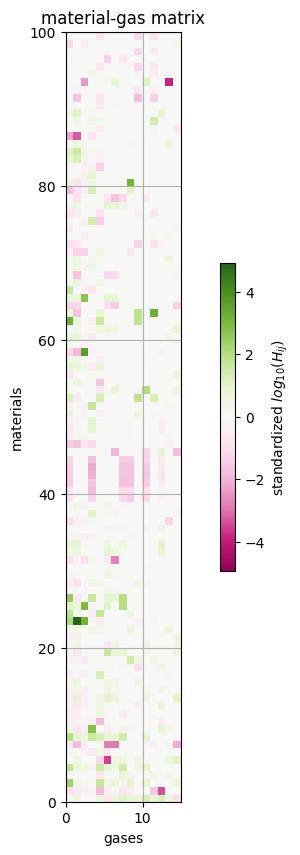

In [349]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

fig, ax = subplots(figsize=(10, 10))
pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)
grid("on")
ax.set_aspect("equal")
title("material-gas matrix")
xlabel("gases")
ylabel("materials")
# TODO xticks, yticks with material and gas names
# xticks(1:ng, gases, rotation=90)
# yticks(1:nm, materials);


## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [350]:
H = collect(H')

15×100 Array{Union{Missing, Float64},2}:
  0.353289  -0.9951        2.36385    …    missing  -1.15839     missing
  0.535128  -0.505556      0.538528        missing    missing    missing
 -0.03352   -0.409656      0.215027        missing  -0.430014    missing
 -0.100015  -0.322186       missing        missing    missing    missing
  0.650179  -1.88173       1.71245       -0.167009    missing  -1.03266 
 -0.774655  -0.243654      0.389637   …    missing    missing    missing
  0.621755   0.00162751    0.810376        missing    missing    missing
  1.1252    -0.760722     -0.116777        missing    missing    missing
  0.770543  -0.369792      0.998496        missing    missing    missing
  0.81203     missing       missing      -1.20772     missing  -1.16629 
  1.27162    0.000168994   0.88621    …    missing    missing    missing
  0.816237  -1.52675        missing      -0.647664    missing  -0.909795
  1.27793   -3.35411        missing        missing    missing    missing
  0.590793

# find the optimal low rank model through cross-validation

In [351]:
ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are filled = ", nb_obs / nm / ng)

# observations = 587
fraction entries that are filled = 0.39133333333333337


### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [352]:
r = QuadReg(0.01) # quadratic regularizer on X, Y
k = 1 # rank of matrix we seek

glrm = GLRM(H, QuadLoss(), r, r, k, obs=observations(H), offset=true)

X, Y, ch = fit!(glrm) # H ~ X' * Y

@assert isapprox(impute(glrm), X' * Y)

Fitting GLRM
Iteration 10: objective value = 295.39216549185306


### split the observations into `n_folds` folds.

TODO: ask Prof. Udell how this works when a MOF is missing from a row.

In [353]:
n_folds = 5 # K-fold cross validation
println("running $n_folds-cross validation...")
kfolds = KFold(nb_obs, n_folds=n_folds, shuffle=true);

running 5-cross validation...


## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [354]:
ks = [1, 2, 3] # ranks
γs = 10.0 .^ range(0.0, 2.0, length=15); # regularization params

map rank to color for data visualizations

In [355]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7ffb3d08a358>>

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [356]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately
# TODO ask Prof. Udell what the equivalent of k = 0 would be (it fails here)

# progress meter
p = Progress(n_folds * length(ks) * length(γs))

mse = Dict(k => zeros(length(γs)) for k in ks) # store MSE for each regularization param and k

# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        # loop over folds
        for (train_ids, test_ids) in kfolds
            # train model on training data
            r = QuadReg(γ) # regularizer
            # trick: use H' to add row offsets
            glrm = GLRM(H, QuadLoss(), r, r, k, obs=ids_obs[train_ids], offset=true)
            X, Y, ch = fit!(glrm, verbose=false) # H ~ X' * Y
            
            # assess error on test data
            Ĥ = impute(glrm)
            H_pred = [Ĥ[i, j] for (i, j) in ids_obs[test_ids]]
            H_actual = [H[i, j] for (i, j) in ids_obs[test_ids]]
            mse[k][i_γ] += sum((H_pred .- H_actual) .^ 2) / length(test_ids)
            ProgressMeter.next!(p)
        end
    end
    mse[k] /= n_folds
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

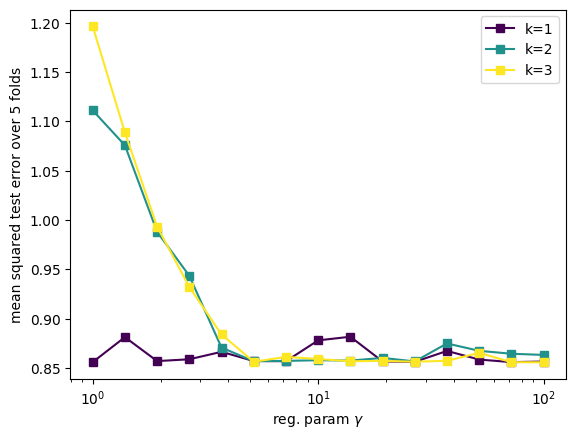

PyObject <matplotlib.legend.Legend object at 0x7ffb3ce18940>

In [358]:
figure()
xlabel(L"reg. param $\gamma$")
ylabel("mean squared test error over $n_folds folds")
for k in ks
    plot(γs, mse[k], label="k=$k", marker="s", color=rank_to_color(k))
end
xscale("log")
legend()

## work with optimal model

In [339]:
min_mse = [minimum(mse[k]) for k in ks]
opt_k = ks[argmin(min_mse)] # optimum rank
opt_γ = γs[argmin(mse[opt_k])]

@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

optimum γ = 3.728, optimum k = 1


### parity plot over `n_folds`-cross validation

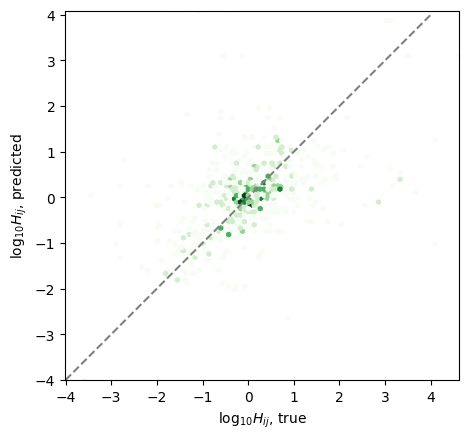

0-element Array{Any,1}

In [340]:
H_actual = Float64[]
H_pred = Float64[]
for (train_ids, test_ids) in kfolds
    # train model on training data
    r = QuadReg(opt_γ) # regularizer
    glrm = GLRM(H, QuadLoss(), r, r, opt_k, obs=ids_obs[train_ids], offset=true)
    X, Y, ch = fit!(glrm, verbose=false) # H ~ X' * Y
    
    # test
    Ĥ = impute(glrm)
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids]])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids]])
end

fig, ax = subplots()
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
ax.set_aspect("equal")
plot([-4, 4], [-4, 4], linestyle="--", color="gray")
plot()

## viz offsets and latent space on fully trained model

In [341]:
r = QuadReg(opt_γ) # regularizer
glrm = GLRM(H, QuadLoss(), r, r, opt_k, obs=ids_obs, offset=true)
X, Y, ch = fit!(glrm, verbose=false) # H ~ X' * Y

([1.0 1.0 … 1.0 1.0], [0.35143068734972205 -0.7614864614798288 … -0.3920603689595292 -0.5297369689117642], ConvergenceHistory("ProxGradGLRM", [Inf, 657.715233185063, 477.3626250688556, 417.26076914098354, 370.8965681488706, 319.85466554148127, 290.48409815423656, 283.0810735333179, 281.3801096216675, 280.87131634530584, 280.6898384387089, 280.55185419781697, 280.41856200329914, 280.3291158060643, 280.31245610116275], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0009639263153076172, 0.018544912338256836, 0.020702838897705078, 0.02198195457458496, 0.02332305908203125, 0.02474498748779297, 0.02625894546508789, 0.027307987213134766, 0.028249025344848633, 0.0292661190032959, 0.030170202255249023, 0.031087160110473633, 0.03212428092956543, 0.03298211097717285], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0))

### offsets $\mu_i$ representing material biases

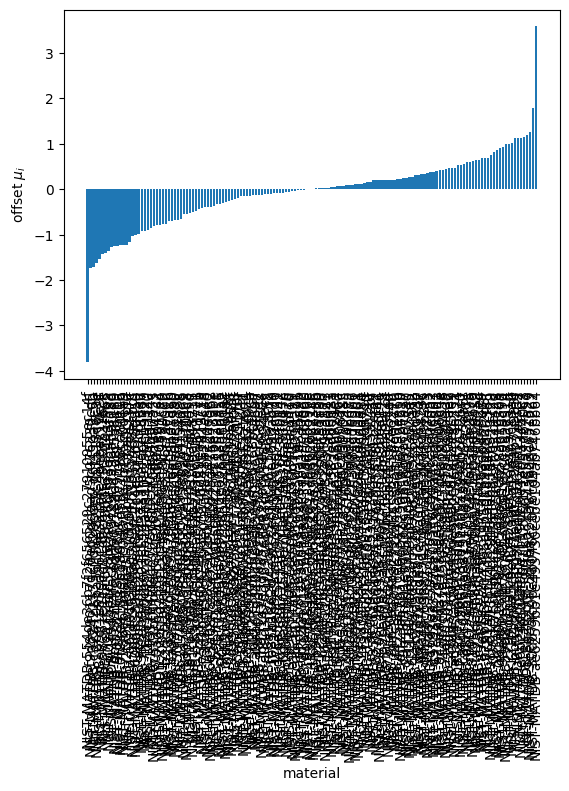

In [342]:
μ = Y[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

### latent space of materials